# Counting houses and all that jazz
## Stuff to do 
- [x] Deduplicate
- [x] Filter to only fjernvarme and gas
- [ ] Estimate bolig per building
- [x] Calculate all the distances
- [ ] CHANGE DISTANCE CALCULATIONS TO UTM / EUCLIDIAN
- [ ] FIGURE OUT WHY EVERYONE IS SO CLOSE TO FJERNVARME?????

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import logging
import src.geo_transform as gt
from typing import Union

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

In [2]:

def camel_to_snake(col: Union[pd.Series, pd.Index]) -> pd.Series:
    return col.str.replace("([a-z])([A-Z])", r"\1_\2", regex=True).str.lower()
def remove_bygning(cols: pd.Index) -> pd.Index:
    return cols.str.replace("byg\d+", "", regex=True)
def clean_columns(df: pd.DataFrame) -> None:
    df.columns = camel_to_snake(remove_bygning(df.columns))

In [3]:
DATA_DIR = Path("data")
df = pd.read_feather(DATA_DIR / "select_bbr2.feather")
clean_columns(df)
df.fillna(value=np.nan, inplace=True)
dtypes = {"varmeinstallation": "int8", 
          "opvarmningsmiddel": "float",
          }
df = df.astype(dtypes)
df = df[~df["koordinat"].isin(['POINT(0 0)', 'POINT(0 0.5)'])]
# make into category
df["bygningens_anvendelse"] = df["bygningens_anvendelse"].astype("category")

## Finding out how many live each place
- [ ] Tjek hvor mange boliger der er per bygning

In [4]:
df["bygningens_anvendelse"].unique()

['930', '510', '120', '190', '110', ..., '990', '999', '121', '444', '122']
Length: 105
Categories (104, object): ['110', '120', '121', '122', ..., '960', '970', '990', '999']

In [5]:
anvendelse = pd.read_csv("anvendelse.csv")
anvendelse["anvendelseskode"] = anvendelse["anvendelseskode"].astype("str").astype("category")

df["bygningens_anvendelse"] = df["bygningens_anvendelse"].astype("category")

In [65]:
helaars = anvendelse[anvendelse["kategori"] == "Bygninger til helårsbeboelse."]

# inner join df on helaars
helaars_df = df.merge(helaars, how="inner", left_on="bygningens_anvendelse", right_on="anvendelseskode")

In [69]:
helaars_df[["husnummer", "beskrivelse"]].drop_duplicates()

,husnummer,beskrivelse
0,0a3f5090-a68c-32b8-e044-0003ba298018,Fritliggende eenfamilieshus (parcelhus).
1,0a3f5095-0976-32b8-e044-0003ba298018,Fritliggende eenfamilieshus (parcelhus).
2,0a3f507d-a4b9-32b8-e044-0003ba298018,Fritliggende eenfamilieshus (parcelhus).
3,0a3f5094-fedc-32b8-e044-0003ba298018,Fritliggende eenfamilieshus (parcelhus).
4,0a3f5094-0318-32b8-e044-0003ba298018,Fritliggende eenfamilieshus (parcelhus).
...,...,...
1595935,0a3f509c-549a-32b8-e044-0003ba298018,Kollegium.
1595936,0a3f509c-17d9-32b8-e044-0003ba298018,Kollegium.
1595937,0a3f507d-c374-32b8-e044-0003ba298018,Kollegium.
1595938,0a3f509c-6bba-32b8-e044-0003ba298018,Kollegium.


In [72]:
df.columns

Index(['kommunekode', 'registrering_fra', 'virkning_fra',
       'bygningens_anvendelse', 'varmeinstallation', 'husnummer',
       'opvarmningsmiddel', 'revisionsdato', 'kvalitet_af_koordinatsæt',
       'koordinat', 'koordinatsystem', 'ejerlejlighed'],
      dtype='object')

In [71]:
helaars_df["ejerlejlighed"].dropna()

1592       45791a61-5dc3-4f65-9a0d-954abac7d9bd
59153      eac93cd7-3a65-417a-a5ac-e6bed6b25ef1
126552     9c2c1520-91f6-4962-b5e1-dbe128b2641b
127430     dd726bfa-4bd8-41b8-a97c-f353bf7ae990
130793     9cdd5843-e3e1-410c-8108-3610915f4292
                           ...                 
1594227    b835b848-20db-48ad-97bf-0ef7c994bb03
1594228    b835b848-20db-48ad-97bf-0ef7c994bb03
1594232    b835b848-20db-48ad-97bf-0ef7c994bb03
1595467    c6862f51-9cd0-4272-8685-61a8fe5b31f5
1595721    55e732e8-fcf3-4249-8603-979685534e32
Name: ejerlejlighed, Length: 245, dtype: object

In [62]:
anvendelse["anvendelseskode"].unique()

['930', '510', '120', '190', '110', ..., '990', '999', '121', '444', '122']
Length: 105
Categories (104, object): ['110', '120', '121', '122', ..., '960', '970', '990', '999']

## Filtering to only have gas and fjernvarme
I follow the [official documentation from BBR](https://instruks.bbr.dk/varmeinstallation1/0/30). Here I choose `1` (fjernvarme/blokvarme) and `8` (gas) 

In [4]:
uses_gas = df["opvarmningsmiddel"].isin([2, 7]) | df["varmeinstallation"].isin([8])
uses_fjernvarme = df["varmeinstallation"] == 1
logging.info("%s buildings use gas", uses_gas.sum())
logging.info("%s buildings use fjernvarme", uses_fjernvarme.sum())


2022-05-23 10:52:00,640 - root - INFO - 378628 buildings use gas
2022-05-23 10:52:00,658 - root - INFO - 897974 buildings use fjernvarme


## Getting coords for fjernvarme
- Haversine was totally fucked because of floating point shit
- Euclidean 

In [5]:
fjernvarme_koords = df.loc[uses_fjernvarme, ["husnummer", "koordinat"]].drop_duplicates().dropna()
gas_koords = df.loc[uses_gas, ["husnummer", "koordinat"]].drop_duplicates().dropna()

In [6]:
gas_coords = gt.points_to_coords(gas_koords["koordinat"]).astype(float)
fjernvarme_coords = gt.points_to_coords(fjernvarme_koords["koordinat"]).astype(float)

In [12]:
df["husnummer"].unique().shape[0]

2018477

In [7]:
gas_lat, gas_long = gt.points_to_wgs84(gas_koords["koordinat"])
fjernvarme_lat, fjernvarme_long = gt.points_to_wgs84(fjernvarme_koords["koordinat"])

In [26]:
print(f"{gas_lat.max() = }")
print(f"{gas_long.max() = }")
print(f"{gas_long.min() = }")
print(f"{gas_lat.min() = }")
print(f"{fjernvarme_lat.max() = }")
print(f"{fjernvarme_long.max() = }")
print(f"{fjernvarme_long.min() = }")
print(f"{fjernvarme_lat.min() = }")

gas_lat.max() = 57.73800683881866
gas_long.max() = 14.749962423627748
gas_long.min() = 8.105017832729311
gas_lat.min() = 54.69872080822638
fjernvarme_lat.max() = 57.73795404356347
fjernvarme_long.max() = 15.150033834562564
fjernvarme_long.min() = 8.109777986434672
fjernvarme_lat.min() = 54.57082859765103


## Testing Euclidean distance

In [8]:
# Euclidian distance with kdtree
from sklearn.neighbors import KDTree

tree = KDTree(fjernvarme_coords, leaf_size=30, metric="euclidean")

# find the closest gas station to each fjernvarme
gas_distances, gas_indices = tree.query(gas_coords, k=1)


In [11]:
SHORT_DIST = 500
LONG_DIST = 1000

short_gas = (gas_distances < SHORT_DIST).sum()
medium_gas = ((LONG_DIST > gas_distances) & (gas_distances > SHORT_DIST)).sum()
long_gas = (gas_distances > LONG_DIST).sum()
logging.info("%s buildings are more short distance out of %s buildings", short_gas,  gas_distances.shape[0])
logging.info("%s buildings are more short distance out of %s buildings", medium_gas,  gas_distances.shape[0])
logging.info("%s buildings are more short distance out of %s buildings", long_gas,  gas_distances.shape[0])

2022-05-23 09:23:25,334 - root - INFO - 254061 buildings are more short distance out of 374562 buildings
2022-05-23 09:23:25,335 - root - INFO - 57004 buildings are more short distance out of 374562 buildings
2022-05-23 09:23:25,336 - root - INFO - 63497 buildings are more short distance out of 374562 buildings


In [14]:
pd.DataFrame({"ID": gas_koords["husnummer"], "lat": gas_lat.reshape(-1), "long": gas_long.reshape(-1), "distance": gas_distances.reshape(-1)}).to_csv("out/gas_distances.csv", index=False)

In [14]:
df["husnummer"].drop_duplicates().shape

(2018477,)

In [15]:
fjernvarme_coords.shape[0]

888315

In [28]:
gas_distances.max()

49167.29290311298

<AxesSubplot:>

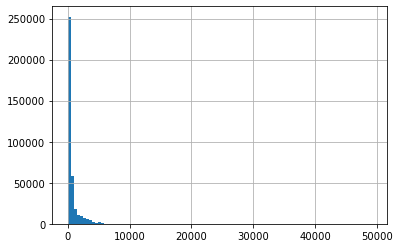

In [29]:
pd.Series(gas_distances.reshape(-1)).hist(bins=100)

In [12]:
from sklearn.neighbors import BallTree

tree = BallTree(fjernvarme_latlon, metric="haversine")
distances, indices = tree.query(gas_latlon, k=1)

In [18]:
earth_radius_m = 6371000
distances_m = distances * earth_radius_m
distances.min()

0.0

In [19]:
indices

array([[359091],
       [822858],
       [ 17789],
       ...,
       [333375],
       [859326],
       [826257]], dtype=int64)

In [12]:
assert gas_dists.shape[0] == gas_arr.shape[0]
assert gas_dists.shape[1] == fjernvarme_latlon.shape[0]

In [22]:
#gaslat, gaslong = gt.points_to_wgs84(gas_koords["koordinat"])
gasx, gasy = gt.get_xy_from_points(gas_koords["koordinat"])
fjernvarme_x, fjernvarme_y = gt.get_xy_from_points(fjernvarme_koords["koordinat"])

In [26]:
na_idx = fjernvarme_x.argmin()

fjernvarme_koords["koordinat"].values[na_idx]

'POINT(0 0.5)'

In [15]:
na_idxs = gasx.argmin()

gas_koords["koordinat"].values[na_idxs]

'POINT(0 0)'

In [14]:
df["koordinatsystem"].dropna().unique()

array(['5'], dtype=object)

In [22]:
print(df.shape)
df["varmeinstallation"].value_counts()

(3079428, 10)


1     898015
9     890933
2     696586
7     327417
5     193114
3      51145
6      20640
99       794
8        784
Name: varmeinstallation, dtype: int64